## Data Cleaning and Preprocessing

In [2]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.models import Sequential, Model, load_model
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, Dropout, Convolution1D, MaxPooling1D, SpatialDropout1D, Input 
from keras.layers import GlobalMaxPooling1D, concatenate, LSTM, Bidirectional
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import string
import re
from sklearn.base import BaseEstimator, TransformerMixin

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Using TensorFlow backend.


In [3]:
# Text cleaner found on github: https://github.com/martinpella/twitter-airlines/blob/master/utils.py
class TextCleaner(BaseEstimator, TransformerMixin):    
    def remove_mentions(self, text):        
        return re.sub(r'@\w+', '', text)
    
    def remove_urls(self, text):        
        return re.sub(r'http.?://[^\s]+[\s]?', '', text)
    
    def only_characters(self, text):
        return re.sub('[^a-zA-Z\s]', '', text)
    
    def remove_extra_spaces(self, text):
        text = re.sub("\s+", ' ', text)
        text = text.lstrip()
        return text.rstrip()
    
    def to_lower(self, text):
        return text.lower()
    
    def fix_words(self, text):
        text = re.sub(r'\bthx\b', 'thanks', text)
        text = re.sub(r'\bu\b', 'you', text)
        text = re.sub(r'\bhrs\b', 'hours', text)
        text = re.sub(r'\baa\b', 'a', text)
        text = re.sub(r'\bflightr\b', 'flight', text)
        text = re.sub(r'\bur\b', 'your', text)
        text = re.sub(r'\bhr\b', 'hour', text)
        text = re.sub(r'\bthru\b', 'through', text)
        text = re.sub(r'\br\b', 'are', text)
        text = re.sub(r'\bppl\b', 'people', text)
        text = re.sub(r'\btix\b', 'fix', text)
        text = re.sub(r'\bplz\b', 'please', text)
        text = re.sub(r'\bflightd\b', 'flighted', text)
        text = re.sub(r'\btmrw\b', 'tomorrow', text)
        text = re.sub(r'\bthx\b', 'thanks', text)
        text = re.sub(r'\bpls\b', 'please', text)
        text = re.sub(r'\bfyi\b', 'for your information', text)
        
        text = re.sub(r'\bheyyyy\b', 'hey', text)
        text = re.sub(r'\bguyyyys\b', 'guys', text)
        text = re.sub(r'\byall\b', 'you all', text)
        text = re.sub(r'\basap\b', 'as soon as possible', text)
        text = re.sub(r'\bbtw\b', 'by the way', text)
        text = re.sub(r'\bdm\b', 'direct message', text)
        text = re.sub(r'\bcudtomers\b', 'customers', text)
        text = re.sub(r'\bwtf\b', 'what the fuck', text)
        text = re.sub(r'\biphone\b', 'phone', text)
        text = re.sub(r'\bmins\b', 'minutes', text)
        text = re.sub(r'\btv\b', 'television', text)
        text = re.sub(r'\bokay\b', 'ok', text)
        text = re.sub(r'\bfeb\b', 'february', text)
        text = re.sub(r'\byr\b', 'year', text)
        text = re.sub(r'\bshes\b', 'she is', text)
        text = re.sub(r'\bnope\b', 'no', text)
        text = re.sub(r'\bhes\b', 'he is', text)
        text = re.sub(r'\btill\b', 'until', text)
        text = re.sub(r'\bomg\b', 'oh my god', text)
        text = re.sub(r'\btho\b', 'though', text)
        text = re.sub(r'\bnothappy\b', 'not happy', text)
        return re.sub(r'\bthankyou\b', 'thank you', text)
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):        
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.only_characters).apply(self.remove_extra_spaces).apply(self.to_lower).apply(self.fix_words)
        return clean_X

In [4]:
# load the data
relevant_tweets = pd.read_hdf('datasets/relevant_tweets.h5', 'relevant_tweets')
relevant_tweets['classification'] = 'relevant'
relevant_tweets['binary_class'] = np.ones(len(relevant_tweets)).astype(int)
relevant_tweets = relevant_tweets[['classification', 'binary_class', 'text']]
irrelevant_tweets = pd.read_hdf('datasets/not_relevant_tweets.h5', 'not_relevant_tweets')
irrelevant_tweets['classification'] = 'irrelevant'
irrelevant_tweets['binary_class'] = np.zeros(len(irrelevant_tweets)).astype(int)
irrelevant_tweets = irrelevant_tweets[['classification', 'binary_class', 'text']]
df = pd.concat([relevant_tweets, irrelevant_tweets]).reset_index()
df = df.iloc[:, 1:]
df.head()

,classification,binary_class,text
0,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B..."
1,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep..."
2,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep..."
3,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B..."
4,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B..."


In [5]:
# Clean the text
tc = TextCleaner()
df['cleaned_text'] = tc.transform(df['text'])
df.head()

,classification,binary_class,text,cleaned_text
0,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...",sun sand and sewage report shows many us beach...
1,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep...",many us beaches are unsafe for swimming report...
2,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep...",many us beaches are unsafe for swimming report...
3,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...",sun sand and sewage report shows many us beach...
4,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...",sun sand and sewage report shows many us beach...


In [6]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

df['tokenized'] = df['cleaned_text'].apply(lambda row: tokenize(row))
df.head()

,classification,binary_class,text,cleaned_text,tokenized
0,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...",sun sand and sewage report shows many us beach...,"[sun, sand, and, sewage, report, shows, many, ..."
1,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep...",many us beaches are unsafe for swimming report...,"[many, us, beaches, are, unsafe, for, swimming..."
2,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep...",many us beaches are unsafe for swimming report...,"[many, us, beaches, are, unsafe, for, swimming..."
3,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...",sun sand and sewage report shows many us beach...,"[sun, sand, and, sewage, report, shows, many, ..."
4,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...",sun sand and sewage report shows many us beach...,"[sun, sand, and, sewage, report, shows, many, ..."


In [7]:
df = df.drop_duplicates(subset = ['cleaned_text']).reset_index()
df = df.iloc[:, 1:]
print(len(df))
df.head()

62688


,classification,binary_class,text,cleaned_text,tokenized
0,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...",sun sand and sewage report shows many us beach...,"[sun, sand, and, sewage, report, shows, many, ..."
1,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep...",many us beaches are unsafe for swimming report...,"[many, us, beaches, are, unsafe, for, swimming..."
2,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep...",many us beaches are unsafe for swimming report...,"[many, us, beaches, are, unsafe, for, swimming..."
3,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...",sun sand and sewage report shows many us beach...,"[sun, sand, and, sewage, report, shows, many, ..."
4,relevant,1,"Thanks, EPA.\n\nSun, Sand And Sewage: Report S...",thanks epa sun sand and sewage report shows ma...,"[thanks, epa, sun, sand, and, sewage, report, ..."


In [8]:
from nltk.corpus import stopwords

In [9]:
import collections
stop = set(stopwords.words('english'))
stop.update(['amp', 'rt', 'cc'])
stop = stop - set(['no', 'not'])

def remove_stopwords(row):
    return [t for t in row if t not in stop]

df['tokenized'] = df['tokenized'].apply(lambda row: remove_stopwords(row))

df = df[['classification', 'binary_class', 'text', 'tokenized']]
vocab_counter = collections.Counter()

In [10]:
tokens = np.array(df['tokenized']).reshape(-1, 1)
words = []
for i in range(len(tokens)):
    tweet = tokens[i]
    for j in range(len(tweet)):
        new_word = tweet[j]
        words.append(new_word)

print(type(words))
indivs = []
for tweet in range(len(words)):
    t = words[tweet]
    for j in range(len(t)):
        indivs.append(t[j])
indivs[:2]

<class 'list'>


['sun', 'sand']

In [11]:
vocabulary_size = 10000
from collections import Counter

# UNK = unknown words, HST = hashtag, EMT = emoticon, URL is self-explanatory, THDL = Twitter handle
vocabulary = [("<UNK>", None)] + [("<PAD>", None)] + Counter(indivs).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in indivs])
print(len(vocabulary))
#print(len(data))

10001


In [12]:
lengths = df['tokenized'].apply(lambda x: len(x))
print(max(lengths), min(lengths), np.mean(lengths))

53 0 13.877185426237876


In [13]:
word_to_id = {w:i for i, w in enumerate(vocabulary[:25000])}

In [17]:
#word_to_id['<UNK>'] = 0
print(type(word_to_id))
print(word_to_id)

<class 'dict'>
{'<UNK>': 0, '<PAD>': 1, 'water': 2, 'not': 3, 'flood': 4, 'flash': 5, 'like': 6, 'no': 7, 'oil': 8, 'spill': 9, 'im': 10, 'people': 11, 'dont': 12, 'one': 13, 'warning': 14, 'get': 15, 'know': 16, 'time': 17, 'pm': 18, 'would': 19, 'contamination': 20, 'drought': 21, 'watch': 22, 'us': 23, 'see': 24, 'think': 25, 'good': 26, 'even': 27, 'still': 28, 'go': 29, 'well': 30, 'thats': 31, 'love': 32, 'want': 33, 'county': 34, 'much': 35, 'back': 36, 'could': 37, 'really': 38, 'also': 39, 'make': 40, 'de': 41, 'sanitation': 42, 'algae': 43, 'got': 44, 'drinking': 45, 'going': 46, 'way': 47, 'new': 48, 'cant': 49, 'right': 50, 'said': 51, 'never': 52, 'waste': 53, 'today': 54, 'bloom': 55, 'say': 56, 'take': 57, 'work': 58, 'day': 59, 'years': 60, 'first': 61, 'youre': 62, 'please': 63, 'need': 64, 'many': 65, 'via': 66, 'que': 67, 'didnt': 68, 'issued': 69, 'last': 70, 'look': 71, 'life': 72, 'sewage': 73, 'july': 74, 'rain': 75, 'clean': 76, 'help': 77, 'cdt': 78, 'trump': 7

In [18]:
# transform token by id
def transform_to_ids(row):
    return [word_to_id[w] if w in word_to_id else word_to_id['<UNK>'] for w in row]


df['token_int'] = df['tokenized'].apply(lambda x: transform_to_ids(x))
df.head()

,classification,binary_class,text,tokenized,token_int
0,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...","[sun, sand, sewage, report, shows, many, us, b...","[872, 1795, 73, 267, 467, 65, 23, 311, 1506, 546]"
1,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep...","[many, us, beaches, unsafe, swimming, report, ...","[65, 23, 311, 1506, 546, 267, 467]"
2,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep...","[many, us, beaches, unsafe, swimming, report, ...","[65, 23, 311, 1506, 546, 267, 0]"
3,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...","[sun, sand, sewage, report, shows, many, us, b...","[872, 1795, 73, 267, 467, 65, 23, 311, 1506, 5..."
4,relevant,1,"Thanks, EPA.\n\nSun, Sand And Sewage: Report S...","[thanks, epa, sun, sand, sewage, report, shows...","[199, 1202, 872, 1795, 73, 267, 467, 65, 23, 3..."


In [24]:
# set the max_length
max_length = 35

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['token_int'].values, df['binary_class'].values,
                                                   test_size = 0.2, random_state = 42)

In [25]:
# padding our sequences
X_train = pad_sequences(X_train, maxlen = max_length, value = 1, padding = 'post', truncating = 'post')
X_test = pad_sequences(X_test, maxlen = max_length, value = 1, padding = 'post', truncating = 'post')

In [26]:
X_train[0]

array([ 262,  764,  298,  157, 4529,  764, 7554,  298, 2676,  234,   79,
        203,  252,  637, 1008,  267,  703,    2,  225,  739, 2515,  158,
         19,  108, 2534,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1])

## Working CNN

``` python
# creating the embedding matrix
embedding_index = {}

trained_embeds = open('my_final_embeddings_tweets.npy', 'rb')
for line in trained_embeds:
    #if 
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
trained_embeds.close()
```

In [29]:
# We now create a neural network that applies different filter sizes (2 and 3) 
# to word vectors, then concatenate the outputs and apply a classifier on top on that.
# We make a multi-layered CNN with an embedding layer dimension of 128
reset_graph()

def multilayer_cnn():
    # I read that it was wise to choose an embedding size between 32 and 512, I chose 128
    # This is certainly a parameter that we should try to play around with
    graph_input = Input(shape = (10001, 128))
    
    convolutions = []
    for filter_size in range(2, 4):
        # We take convolutions of size 2 and 3, concatenate the inputs and apply a classifier on top of it
        # We have same padding, and we use the ReLU activation function to the top of this after feeding
        # the 128D embedding. This uses a default of the skip gram model.
        X = Convolution1D(128, filter_size, padding = 'same', activation = 'relu')(graph_input)
        convolutions.append(X)
        
    # concatenating the convolutions     
    graph_output = concatenate(convolutions, axis = 1)
    # Takes pooling windows of 2 (default) for size of pooling windows. We retain the maximum value
    # Channels last is the default, takes inputs of (batch, steps, features)
    graph_output = GlobalMaxPooling1D()(graph_output)
    # Creating our CNN layers
    graph = Model(graph_input, graph_output)
    
    model = Sequential([Embedding(10001, 128, input_length = max_length),
                    graph,
                    # Applies dropout to 50% of the randomly selected neurons to reduce sensitivity to small
                    # changes in the data
                    Dropout(0.5),
                    # Feed the 64 neurons (after dropout) to a fully connected layer of 32 neurons, 
                    # activation function once again is the ReLU
                    Dense(32, activation='relu'),
                    # Feed to the output layer of 2 neurons ['Relevant', 'Irrelevant']
                    Dense(2, activation='softmax')])
    
    # How we compile the model, uses categorical cross entropy which essentially tries to penalize
    # the model when it predicts a low probability in the target class. An ADAM optimizer uses ideas from
    # the adaptive gradient algorithm and root mean square propogation algorithm, Instead of adapting the 
    # parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes 
    # use of the average of the second moments of the gradients (the uncentered variance).
    # Source: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
    model.compile(loss='categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])
    
    return model

In [30]:
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Using a KerasClassifier to train a model. Our CNN is used as the build function, we train the model 
# for 25 epochs, and we take batches of 1024 tweets at a time to train each model.
estimator = KerasClassifier(build_fn = multilayer_cnn, epochs=25, batch_size = 1024, verbose = 0)
# Takes a stratified k-fold (proportional sampling of classes), splits it into 5 folds. 
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [31]:
results = cross_val_score(estimator, X_train, y_train, cv = kfold)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [32]:
results.mean(), results.std()

(0.9620140731327173, 0.0017855619412871792)

In [35]:
y_train_2 = np_utils.to_categorical(y_train)
#print(y_train)

In [36]:
y_test_2 = np_utils.to_categorical(y_test)
#print(y_test)

In [37]:
# Add checkpoint and use most accurate model from the epochs
# Best model based on maximum accuracy
best_model = ModelCheckpoint('trained_models/best_trained_model.hdf5', monitor = 'val_acc', verbose = 1,
                             save_best_only = True, mode = 'max')
# Save the best model
model_to_use = [best_model]

model = multilayer_cnn()
model.fit(X_train, y_train_2, validation_data = (X_test, y_test_2), epochs = 10, batch_size = 1024, callbacks = model_to_use)
predictions = model.predict(X_test)

Train on 50150 samples, validate on 12538 samples
Epoch 1/10
50150/50150 [==============================] - 46s 916us/step - loss: 0.4291 - acc: 0.8112 - val_loss: 0.1177 - val_acc: 0.9679

Epoch 00001: val_acc improved from -inf to 0.96794, saving model to trained_models/best_trained_model.hdf5
Epoch 2/10
50150/50150 [==============================] - 46s 910us/step - loss: 0.1000 - acc: 0.9710 - val_loss: 0.0928 - val_acc: 0.9739

Epoch 00002: val_acc improved from 0.96794 to 0.97392, saving model to trained_models/best_trained_model.hdf5
Epoch 3/10
50150/50150 [==============================] - 52s 1ms/step - loss: 0.0695 - acc: 0.9787 - val_loss: 0.0953 - val_acc: 0.9730

Epoch 00003: val_acc did not improve from 0.97392
Epoch 4/10
50150/50150 [==============================] - 46s 909us/step - loss: 0.0528 - acc: 0.9839 - val_loss: 0.1043 - val_acc: 0.9711

Epoch 00004: val_acc did not improve from 0.97392
Epoch 5/10
50150/50150 [==============================] - 48s 949us/step - 

In [38]:
print(metrics.accuracy_score(y_test, np.argmax(predictions, axis=1)))
print(metrics.classification_report(y_test, np.argmax(predictions, axis=1), target_names = ['Irelevant', 'Relevant']))

0.9658637741266549
              precision    recall  f1-score   support

   Irelevant       0.97      0.97      0.97      7191
    Relevant       0.96      0.95      0.96      5347

    accuracy                           0.97     12538
   macro avg       0.97      0.96      0.97     12538
weighted avg       0.97      0.97      0.97     12538



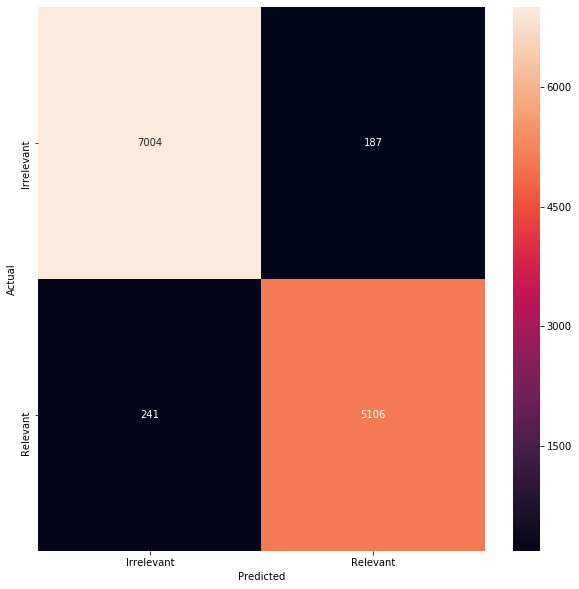

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, np.argmax(predictions, axis = 1))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['Irrelevant', 'Relevant'], yticklabels=['Irrelevant', 'Relevant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

## Try to input raw text
__Note: check spellings and implement new cleaner__

In [40]:
my_tweet_rel = "Algal bloom closes 31st Street Beach in Chicago"

In [54]:
my_not_rel_tweet = "Hot singles in your area near you"
neutral = "I drank water today."
political = "These darn Dems want to regulate everything and put chemicals in the water to turn the frogs gay"
drought = "Crops dying in Midwest as drought reaches record 3 months"
chemical = "Mercury levels in the Milwaukee River reach an all time high as spill releases thousands of gallons of waste water"

tweet_list = {'tweet': [my_tweet_rel, my_not_rel_tweet, neutral, drought, chemical, political]}
tweets = pd.DataFrame(data = tweet_list)

In [55]:
tweets.head()

,tweet
0,Algal bloom closes 31st Street Beach in Chicago
1,Hot singles in your area near you
2,I drank water today.
3,Crops dying in Midwest as drought reaches reco...
4,Mercury levels in the Milwaukee River reach an...


In [56]:
tweets['clean'] = tc.transform(tweets['tweet'])
tweets.head(2)

,tweet,clean
0,Algal bloom closes 31st Street Beach in Chicago,algal bloom closes st street beach in chicago
1,Hot singles in your area near you,hot singles in your area near you


In [57]:
tweets['tokenized'] = tweets['clean'].apply(lambda row: tokenize(row))
tweets.head()

,tweet,clean,tokenized
0,Algal bloom closes 31st Street Beach in Chicago,algal bloom closes st street beach in chicago,"[algal, bloom, closes, st, street, beach, in, ..."
1,Hot singles in your area near you,hot singles in your area near you,"[hot, singles, in, your, area, near, you]"
2,I drank water today.,i drank water today,"[i, drank, water, today]"
3,Crops dying in Midwest as drought reaches reco...,crops dying in midwest as drought reaches reco...,"[crops, dying, in, midwest, as, drought, reach..."
4,Mercury levels in the Milwaukee River reach an...,mercury levels in the milwaukee river reach an...,"[mercury, levels, in, the, milwaukee, river, r..."


In [59]:
tweets['token_int'] = tweets['tokenized'].apply(lambda x: transform_to_ids(x))
tweets.head(6)

,tweet,clean,tokenized,token_int
0,Algal bloom closes 31st Street Beach in Chicago,algal bloom closes st street beach in chicago,"[algal, bloom, closes, st, street, beach, in, ...","[1445, 55, 2042, 241, 526, 257, 0, 1653]"
1,Hot singles in your area near you,hot singles in your area near you,"[hot, singles, in, your, area, near, you]","[289, 0, 0, 0, 88, 225, 0]"
2,I drank water today.,i drank water today,"[i, drank, water, today]","[0, 6009, 2, 54]"
3,Crops dying in Midwest as drought reaches reco...,crops dying in midwest as drought reaches reco...,"[crops, dying, in, midwest, as, drought, reach...","[1925, 1274, 0, 3790, 0, 21, 5696, 651, 440]"
4,Mercury levels in the Milwaukee River reach an...,mercury levels in the milwaukee river reach an...,"[mercury, levels, in, the, milwaukee, river, r...","[3545, 502, 0, 0, 9690, 130, 1439, 0, 0, 17, 1..."
5,These darn Dems want to regulate everything an...,these darn dems want to regulate everything an...,"[these, darn, dems, want, to, regulate, everyt...","[0, 0, 1375, 33, 0, 5699, 212, 0, 142, 832, 0,..."


In [60]:
toy =  pad_sequences(tweets['token_int'].values, maxlen = max_length, value = 1,
                                  padding = 'post', truncating = 'post')
print(toy)

[[1445   55 2042  241  526  257    0 1653    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1]
 [ 289    0    0    0   88  225    0    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1]
 [   0 6009    2   54    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1]
 [1925 1274    0 3790    0   21 5696  651  440    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1]
 [3545  502    0    0 9690  130 1439    0    0   17  182    0    9 6012
   988    0  365    0   53    2    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1]
 [   0    0 1375   33    0 5699  212    0  142  832    0    0    2    0
   395    0 7831 1

In [61]:
model.predict(toy)

array([[2.0444328e-07, 9.9999976e-01],
       [9.2046124e-01, 7.9538733e-02],
       [3.6581794e-06, 9.9999630e-01],
       [4.1914182e-06, 9.9999583e-01],
       [2.5104922e-07, 9.9999976e-01],
       [5.6834298e-04, 9.9943167e-01]], dtype=float32)

In [ ]:
print(np.)